**Conceptual Aerospace Systems Design - Mission**
<br>
**Orbit Analysis**

In [574]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [575]:
## Altitude in Km
input_H = 500
days = 366/2
area = 0.06

In [576]:
## Constants:
mu = 3.986e14 #m^3
omega_earth = 2*math.pi/86400
Re = 6378100
Veq = omega_earth*Re
V0 = math.sqrt(mu/Re)
g = 9.80665
Sw = 10000
Me = 5.98E+24
G = 6.67E-11

In [577]:
def roundTen(n):
    rem = n % 10
    if rem < 5:
        n = int(n / 10) * 10
    else:
        n = int((n + 10) / 10) * 10
    return n

**Orbit Decay Section**

In [578]:
def orbitDecay(H=500, M=6, A=area, F10=70, Ap=10):

    time = []
    height = []

    # Declare Constants
    T = 0
    dT = 0.1
    D9 = dT * 3600 * 24
    H1 = 10
    H2 = H
    R = Re + H * 1000
    P = 2 * math.pi * math.sqrt(R * R * R / Me / G)

    # Iterative Numerical Scheme
    while H > 180:
        SH = (900 + 2.5 * (F10 - 70) + 1.5 * Ap) / (27 - 0.012 * (H - 200))
        DN = 6e-10 * math.exp(-(H - 175) / SH)
        dP = 3 * math.pi * A / M * R * DN * D9

        if H <= H2:
            Pm = P / 60
            MM = 1440 / Pm
            nMM = 1440 / ((P - dP)) / 60
            H2 = H2 - H1

        P = P - dP
        T = T + dT
        R = (G * Me * P * P / 4 / math.pi / math.pi) ** .33333
        H = (R - Re) / 1000

        time.append(T)
        height.append(H)

#         time.insert(0, 0)
#         height.insert(0, input_H)

    return time, height

In [579]:
time, height = orbitDecay(input_H)

In [580]:
time_dec, height_dec = orbitDecay(input_H, A = 0.42)

**Orbit Correction Section**

In [581]:
decay_time = np.array(days)
decay_height = np.interp(decay_time, time, height)

In [582]:
print(decay_height)

497.6514512927755


In [583]:
def deltaV_orbitChange(r1,r2):

    r1 *= 1000
    r1 += Re

    r2 *= 1000
    r2 += Re

    delV1 = math.sqrt((2*mu)/(r1) - (2*mu)/(r1+r2)) - math.sqrt(mu/r1)
    delV2 = math.sqrt(mu/r2) - math.sqrt((2*mu)/(r2) - (2*mu)/(r1+r2))

    return delV1 + delV2

In [584]:
deltaV_req = deltaV_orbitChange(decay_height, input_H)
print('The deltaV required is: {0:5f} m/s'.format(deltaV_req))

The deltaV required is: 1.300010 m/s


In [585]:
# m0 = I/(I_sp * g)

def burnTime(deltaV, m0, i_sp = 50, thrust = 5e-3):
    u_e = i_sp * g
    m_final = m0*math.exp(-deltaV/u_e)
    mass_burn = (m0-m_final)*1000
    burn_time = ((m0 * u_e)/(thrust))*(1 - math.exp(-(deltaV)/(u_e)))

    return burn_time, mass_burn

### Plotting Orbital Decay

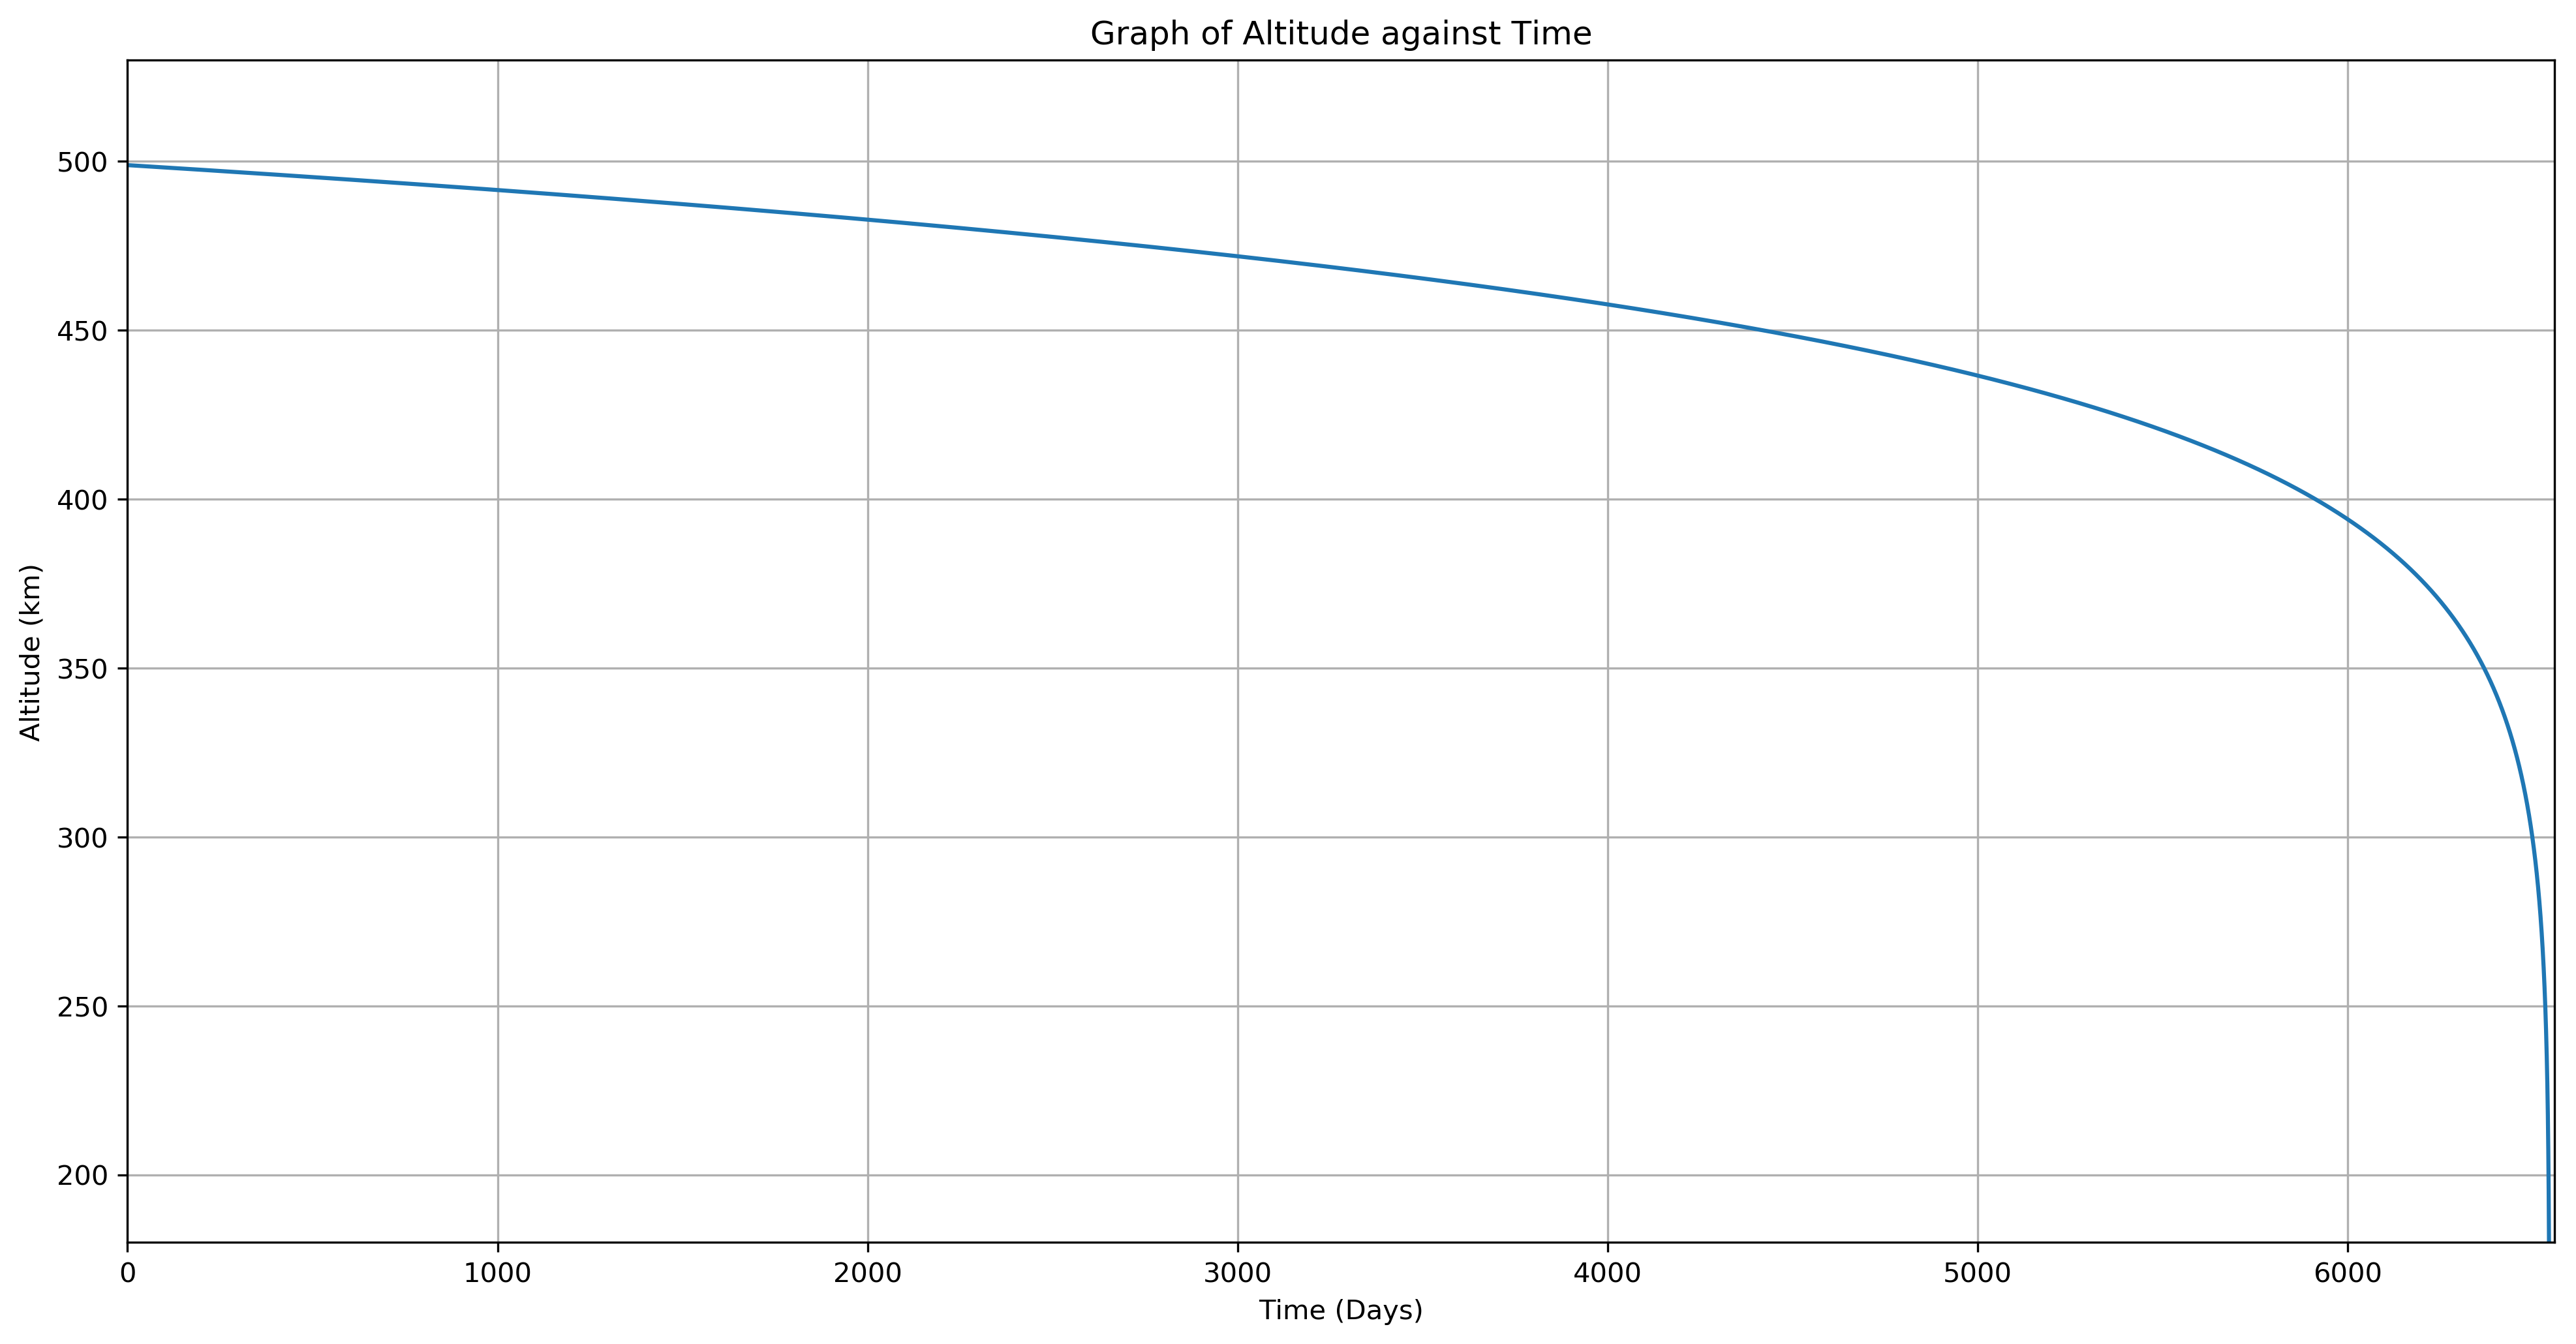

In [586]:
fig = plt.figure(figsize=(16,8), dpi = 300)

plt.plot(time, height)
plt.title('Graph of Altitude against Time')
plt.xlabel('Time (Days)')
plt.ylabel('Altitude (km)')
plt.ylim(180, roundTen(input_H+30))
plt.xlim(0, roundTen(max(time)+20))
plt.grid(True)
plt.show()

# fig.savefig('path/to/save/image/to.png') 
fig.savefig('plots/orbitalDecayTime_Altitude_full_mission.png', bbox_inches='tight')

In [587]:
print(max(time)/365)

17.929863013715828


In [588]:
print('Decay Height: {:.3f}'.format(decay_height))

Decay Height: 497.651


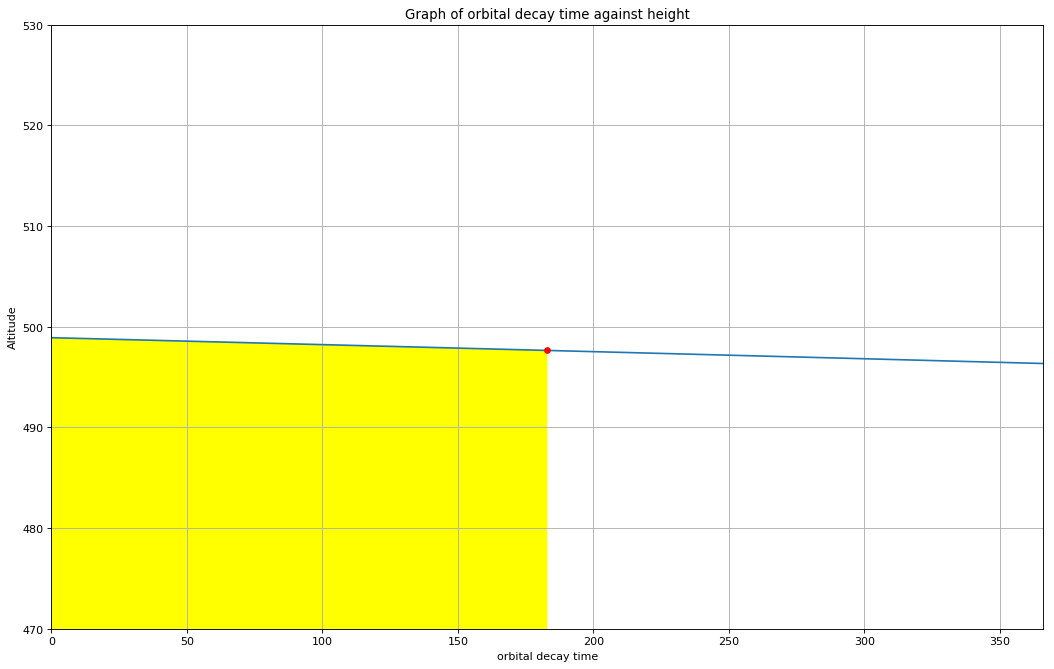

In [589]:
fig = plt.figure(figsize=(16,10), dpi = 80)
ax = plt.subplot(111)
ax.fill_between(time, 0, height, where=(time <= decay_time), facecolor='yellow')

ax.plot(time, height)
ax.plot(decay_time,decay_height,'ro', markersize=5)

plt.title('Graph of orbital decay time against height')
plt.ylabel('Altitude')
plt.xlabel('orbital decay time')
plt.ylim(roundTen(decay_height-30),roundTen(decay_height+30))
plt.xlim(0,2*days)
plt.grid(True)
plt.show()

fig.savefig('plots/orbit/orbitalDecayTime_Altitude.png', bbox_inches='tight')

### Plotting Burn Time against Thrust

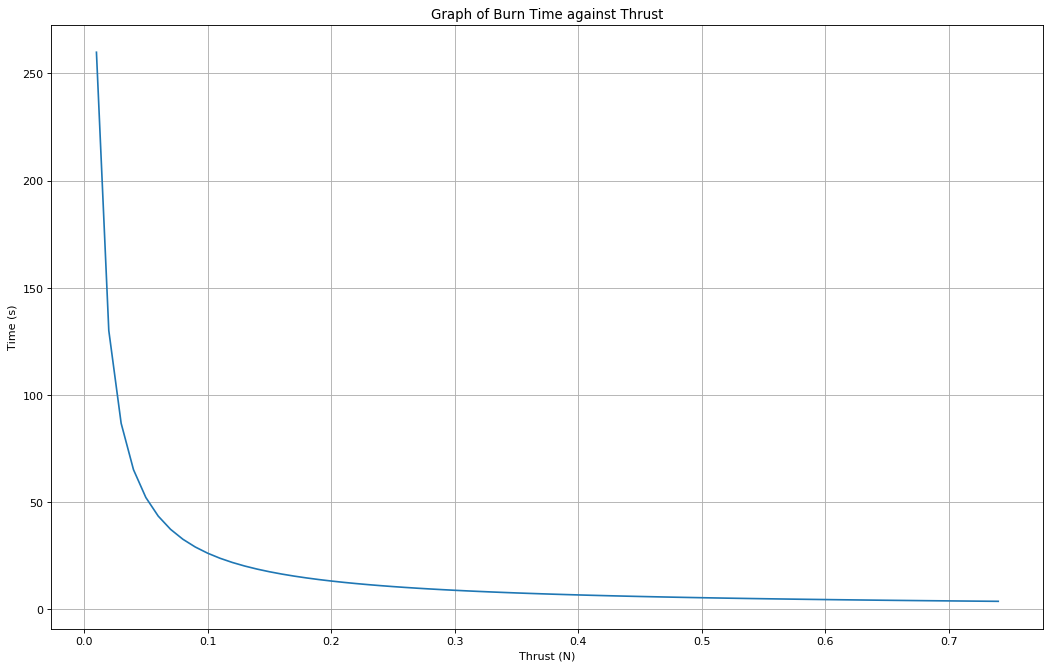

In [590]:
thrust = [x/1e3 for x in range(10,750,10)]

# 0mN to 750mN

i_sp = 220

tmp_time = []
tmp_mass_burn = []

for j in thrust:
    burnTime_req, mass_burn = burnTime(deltaV_req,2,i_sp=i_sp, thrust=j)
    tmp_time.append(burnTime_req)

fig = plt.figure(figsize=(16,10), dpi = 80)
plt.plot(thrust, tmp_time)
plt.title('Graph of Burn Time against Thrust')
plt.xlabel('Thrust (N)')
plt.ylabel('Time (s)')
plt.grid(True)
plt.show()

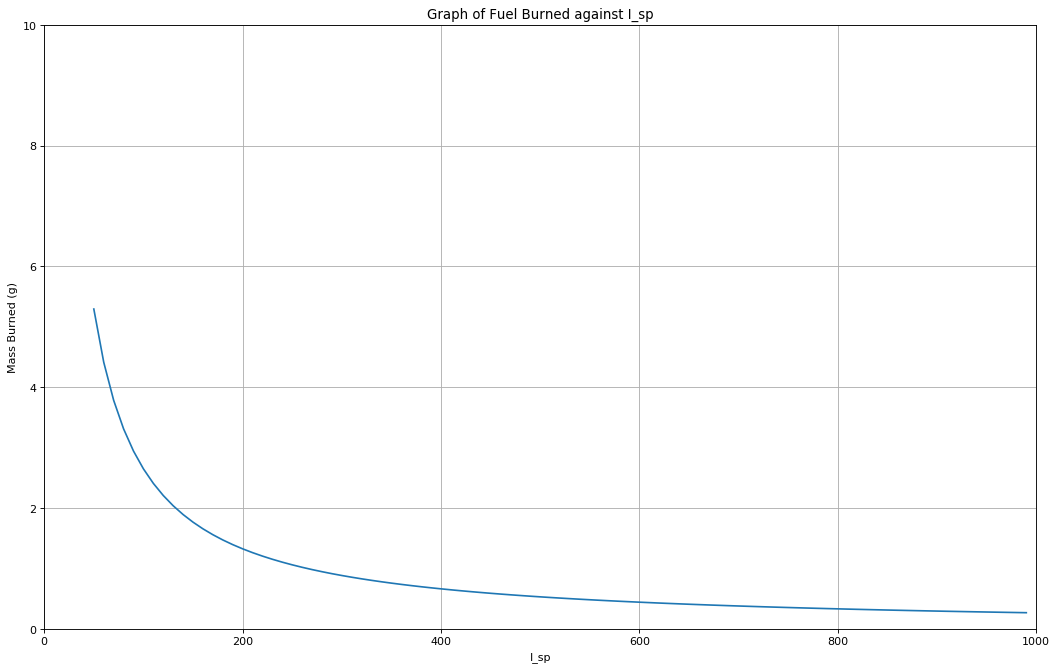

In [591]:
thrust = 500E-3
i_sp = [x for x in range(50,1000,10)]

tmp_mass_burn = []

for j in i_sp:
    burnTime_req, mass_burn = burnTime(deltaV_req,2,i_sp=j, thrust=j)
    tmp_mass_burn.append(mass_burn)

fig = plt.figure(figsize=(16,10), dpi = 80)
plt.plot(i_sp, tmp_mass_burn)
plt.title('Graph of Fuel Burned against I_sp')
plt.xlabel('I_sp')
plt.ylabel('Mass Burned (g)')
plt.ylim(0,10)
plt.xlim(0,1000)
plt.grid(True)
plt.show()

In [592]:
## For a Given Thrust / I_sp
thrust = 500E-3
i_sp = 220
prop_mass = 260

# 2U system
# prop_mass = I_total/(I_sp*g)

dash = '-' * 40

burnTime_req, mass_burn = burnTime(deltaV_req, 3, i_sp=i_sp, thrust=thrust)
print(dash)
print('Burn Frequency: {}days'.format(days))
print(dash)

print('Burn Time Required: {0:.3f}s'.format(burnTime_req))
print('Mass Burned: {0:.3f} g'.format(mass_burn))
print('Number of similar burns possible: {0:.3f}'.format(prop_mass/mass_burn))
print('Years of operation: {0:.3f}'.format((prop_mass/mass_burn)/(365/days)))

----------------------------------------
Burn Frequency: 183.0days
----------------------------------------
Burn Time Required: 7.798s
Mass Burned: 1.807 g
Number of similar burns possible: 143.873
Years of operation: 72.134


### Plotting Orbit

In [593]:
# orbit_height = (input_H*1000)+Re
# cum_t = 0
# cum_theta = 0

# ls_theta = []
# ls_orbit_height = []

# while orbit_height >= (180000+Re):

#     mag_V = math.sqrt(mu/orbit_height)

#     mag_T = (2*math.pi*math.sqrt((orbit_height**3)/mu)) ## seconds
#     deltaT = 1
#     cum_t += deltaT

#     mag_omega = mag_V/orbit_height ## rad/s

#     theta = (mag_omega * deltaT) * (180/math.pi) ## rad
#     cum_theta += theta
#     orbit_height = (np.interp(cum_t, time, height)*1000)+Re ## meters

#     ls_theta.append(cum_theta)
#     ls_orbit_height.append((orbit_height-Re)/1000)

# fig = plt.figure(figsize=(8,8), dpi = 80)
# plt.polar(ls_theta, ls_orbit_height)
# plt.title('Graph of Orbital Height with Position')
# plt.ylim(180,600)
# plt.show()

## Start to Work on EOL Manouevres

In [594]:
def orbitDecayCorrection(H=500, M=6, A=area, F10=70, Ap=10, correction_period = days, mass_fuel=260):

    time = []
    height = []
    
    mass_fuel = mass_fuel
    thrust = 500E-3
    i_sp = 225
    cum_burnTime = 0
    init_H = H

    # Constants
    T = 0
    dT = 0.1
    D9 = dT * 3600 * 24
    H1 = 10
    H2 = H
    R = Re + H * 1000
    P = 2 * math.pi * math.sqrt(R * R * R / Me / G)
    
    counter = 1
    
    while (H > 180) and (mass_fuel > 0):
        
        if not T > (5*365):
        
            R = Re + H * 1000

            if T < (correction_period*counter):
                SH = (900 + 2.5 * (F10 - 70) + 1.5 * Ap) / (27 - 0.012 * (H - 200))
                DN = 6e-10 * math.exp(-(H - 175) / SH)
                dP = 3 * math.pi * A / M * R * DN * D9

                P = P - dP
                T = T + dT
                R = (G * Me * P * P / 4 / math.pi / math.pi) ** .33333
                H = (R - Re) / 1000

                time.append(T)
                height.append(H)

            else:
                deltaV_ret_orbit = deltaV_orbitChange(H, input_H)
                burnTime_req, mass_burn = burnTime(deltaV_ret_orbit, 3, i_sp=i_sp, thrust=thrust)

                cum_burnTime += burnTime_req
                mass_fuel -= mass_burn

                H = init_H

                R = Re + H * 1000
                P = 2 * math.pi * math.sqrt(R * R * R / Me / G)

                T = T + dT
                counter += 1

                time.append(T)
                height.append(H)
                
        else:

            A = 0.42

            SH = (900 + 2.5 * (F10 - 70) + 1.5 * Ap) / (27 - 0.012 * (H - 200))
            DN = 6e-10 * math.exp(-(H - 175) / SH)
            dP = 3 * math.pi * A / M * R * DN * D9

            P = P - dP
            T = T + dT
            R = (G * Me * P * P / 4 / math.pi / math.pi) ** .33333
            H = (R - Re) / 1000

            time.append(T)
            height.append(H)
            
    time.insert(0,0)
    height.insert(0,init_H)

    return time, height, mass_fuel

In [595]:
t,h,mf = orbitDecayCorrection(500)

In [596]:
print(260-mf)

15.89931908428531


In [597]:
ind_rem = [i for i, x in enumerate(h) if x == 500]

for i in sorted(ind_rem, reverse=True):
    del t[i]
    del h[i]

final_t = t
final_h = h

# final_t.extend(list(map(lambda x: x + max(final_t), time)))
# final_h.extend(height)

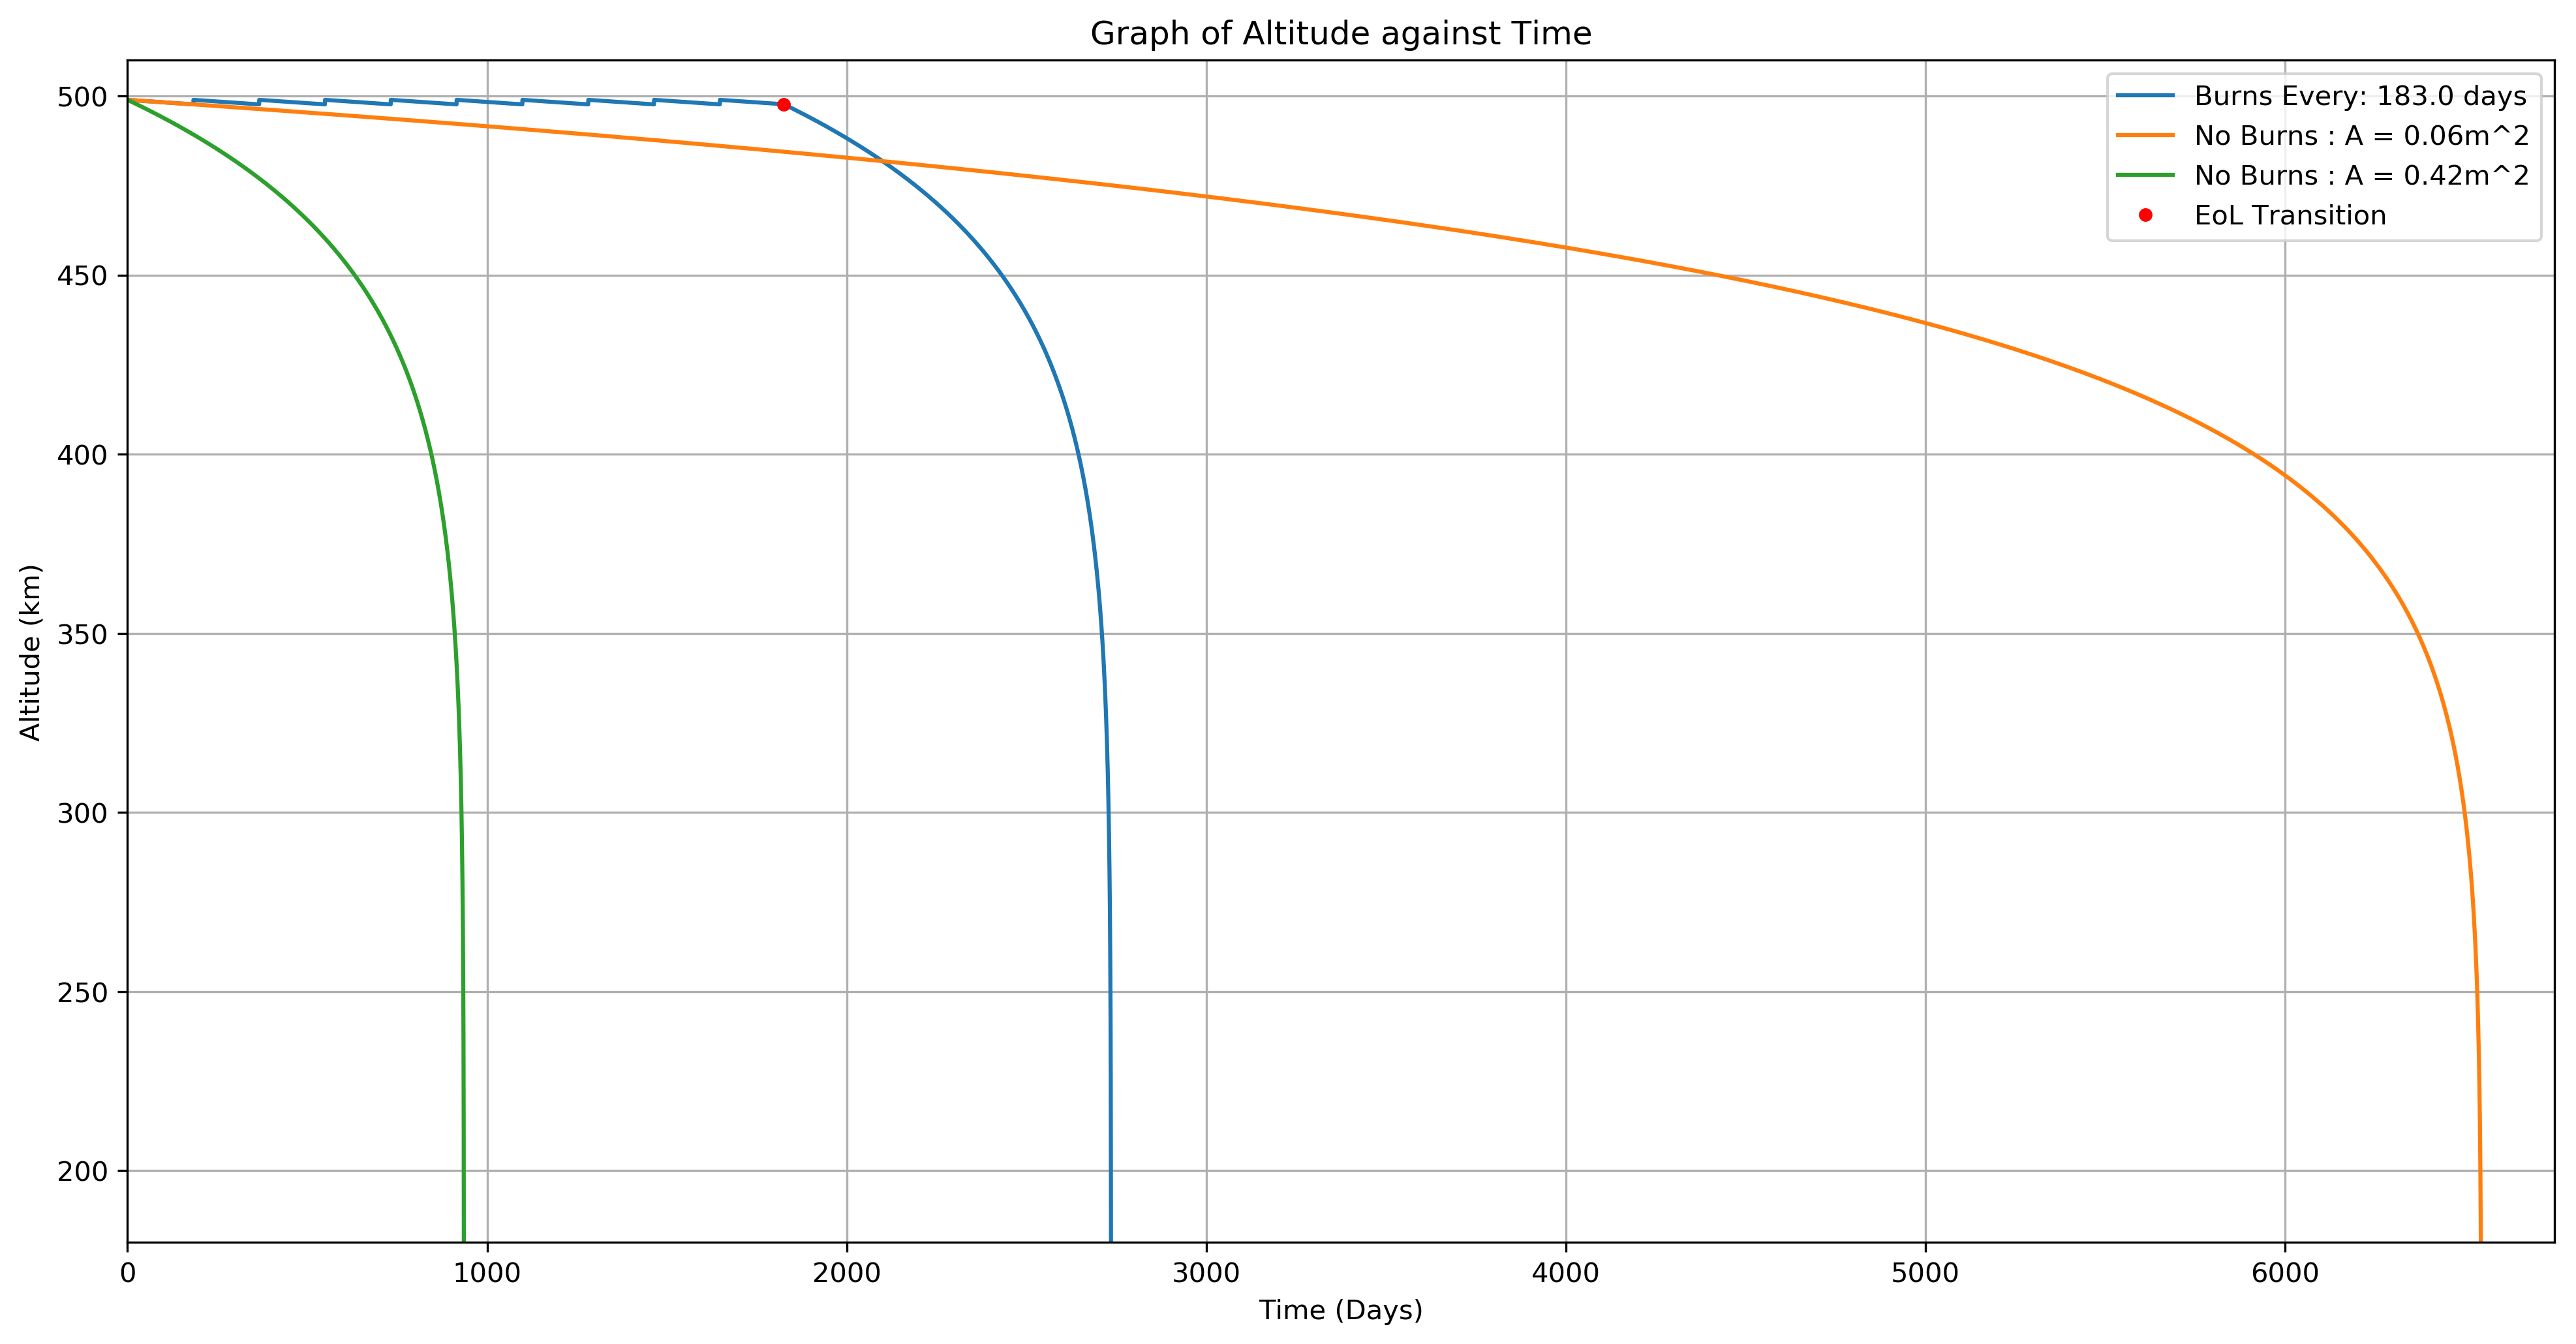

In [598]:
fig = plt.figure(figsize=(16,8), dpi = 300)

five_yr = 365*5

plt.plot(t, h, label=('Burns Every: {} days').format(days))
plt.plot(time,height, label='No Burns : A = 0.06m^2')
plt.plot(time_dec,height_dec, label='No Burns : A = 0.42m^2')

plt.plot(five_yr,decay_height,'ro', markersize=4, label='EoL Transition')

plt.title('Graph of Altitude against Time')
plt.xlabel('Time (Days)')
plt.ylabel('Altitude (km)')

plt.ylim(180,510)
plt.xlim(0,6750)

# plt.ylim(450,510)
# plt.xlim(0,100)

plt.grid(True)
plt.legend()
plt.show()

fig.savefig('plots/orbit/best_graph.png', bbox_inches='tight')

In [599]:
print('Natural Decay for A=0.06m^2: {:.5f} years'.format(max(time)/365))
print('Natural Decay for A=0.42m^2: {:.5f} years'.format(max(time_dec)/365))

Natural Decay for A=0.06m^2: 17.92986 years
Natural Decay for A=0.42m^2: 2.56247 years


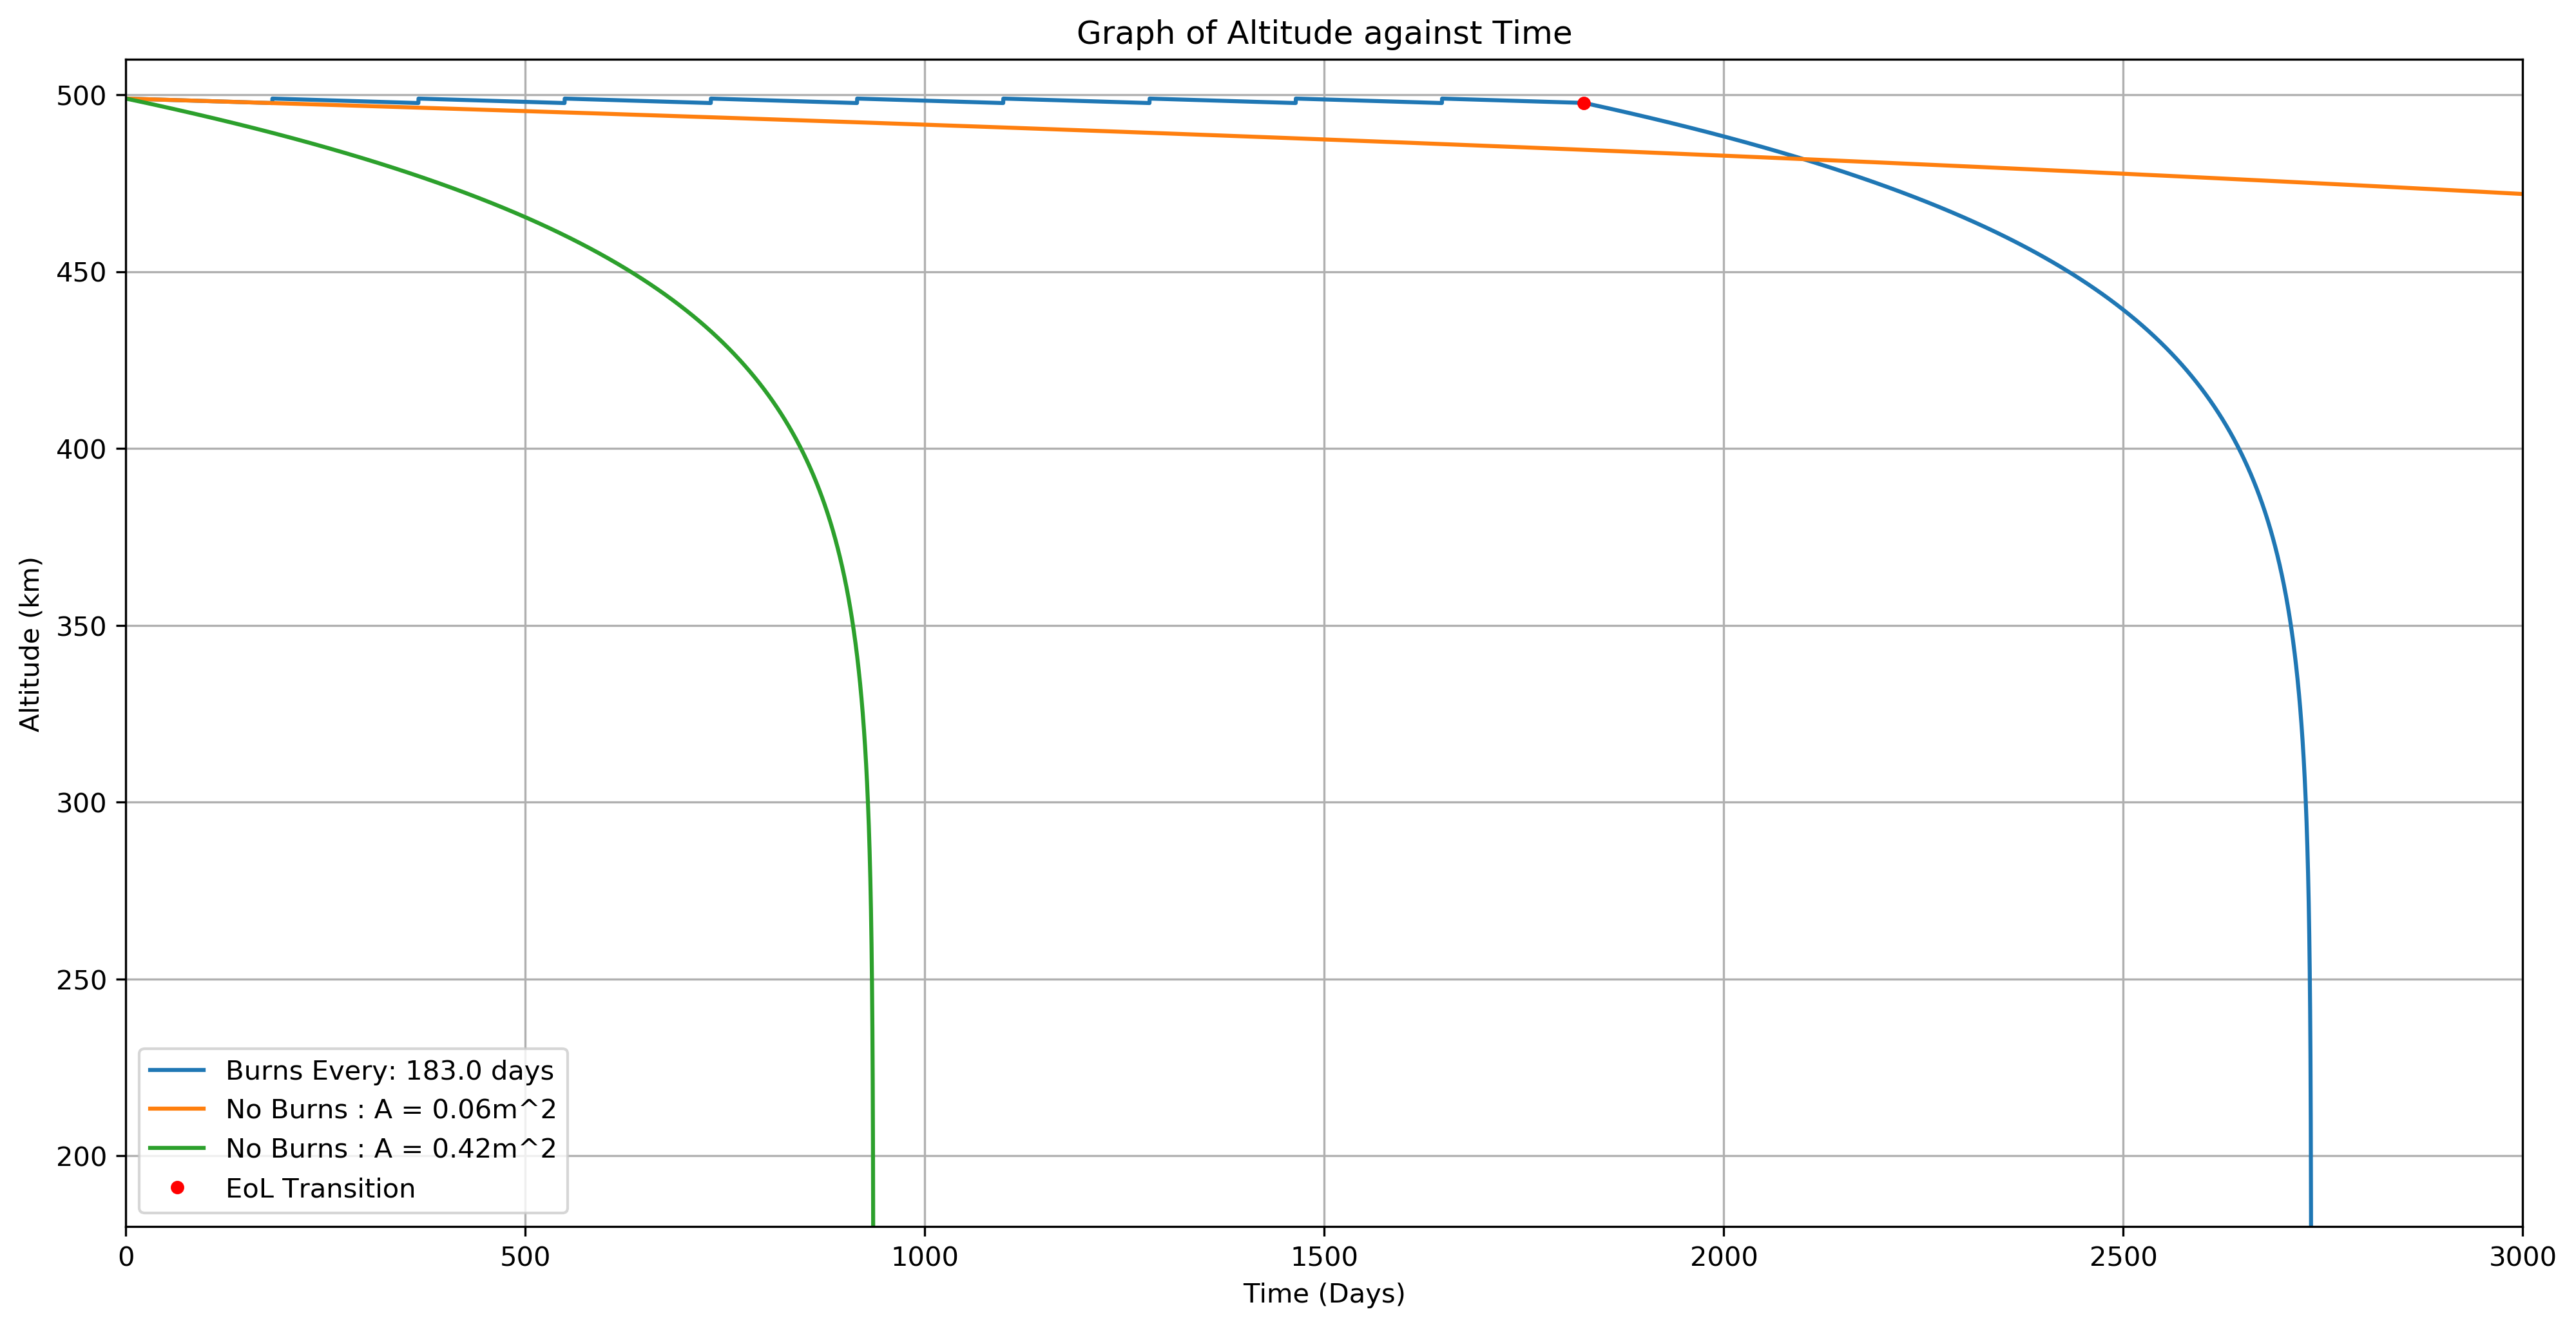

In [600]:
fig = plt.figure(figsize=(16,8), dpi = 300)

five_yr = 365*5

plt.plot(t, h, label=('Burns Every: {} days').format(days))
plt.plot(time,height, label='No Burns : A = 0.06m^2')
plt.plot(time_dec,height_dec, label='No Burns : A = 0.42m^2')

plt.plot(five_yr,decay_height,'ro', markersize=4, label='EoL Transition')

plt.title('Graph of Altitude against Time')
plt.xlabel('Time (Days)')
plt.ylabel('Altitude (km)')

plt.xlim(0,3000)
plt.ylim(180,510)

plt.grid(True)
plt.legend()
plt.show()

In [601]:
print('Mission Life: {:.3f} years'.format(max(t)/365))

Mission Life: 7.493 years


In [610]:
print(365*5)

1825


1. Two Graphs showing each scenario
2. First Graph will show the general effect of orbital burns with time (with a larger area of 0.6 to give good graph)
3. Final graph will show area of 0.06 until 5 years, remaning fuel will be used to burn to lower altitude and satellite will twist creating an area of 0.42

In [603]:
def orbitDecayCorrection_full(H=500, M=6, A=area, F10=70, Ap=10, correction_period = days, mass_fuel=260):

    time = []
    height = []
    
    mass_fuel = mass_fuel
    thrust = 500E-3
    i_sp = 225
    cum_burnTime = 0
    init_H = H

    # Constants
    T = 0
    dT = 0.1
    D9 = dT * 3600 * 24
    H1 = 10
    H2 = H
    R = Re + H * 1000
    P = 2 * math.pi * math.sqrt(R * R * R / Me / G)
    
    counter = 1
    
    while (H > 180) and (mass_fuel > 0):
        
        R = Re + H * 1000

        if T < (correction_period*counter):
            SH = (900 + 2.5 * (F10 - 70) + 1.5 * Ap) / (27 - 0.012 * (H - 200))
            DN = 6e-10 * math.exp(-(H - 175) / SH)
            dP = 3 * math.pi * A / M * R * DN * D9

            P = P - dP
            T = T + dT
            R = (G * Me * P * P / 4 / math.pi / math.pi) ** .33333
            H = (R - Re) / 1000

            time.append(T)
            height.append(H)

        else:
            deltaV_ret_orbit = deltaV_orbitChange(H, input_H)
            burnTime_req, mass_burn = burnTime(deltaV_ret_orbit, 3, i_sp=i_sp, thrust=thrust)

            cum_burnTime += burnTime_req
            mass_fuel -= mass_burn

            H = init_H

            R = Re + H * 1000
            P = 2 * math.pi * math.sqrt(R * R * R / Me / G)

            T = T + dT
            counter += 1

            time.append(T)
            height.append(H)
            
    time.insert(0,0)
    height.insert(0,init_H)

    return time, height, mass_fuel

In [604]:
t_full,h_full,mf_full = orbitDecayCorrection_full(500)

In [605]:
ind_rem = [i for i, x in enumerate(h) if x == 500]

for i in sorted(ind_rem, reverse=True):
    del t[i]
    del h[i]

final_t = t_full
final_h = h_full

final_t.extend(list(map(lambda x: x + max(final_t), time_dec)))
final_h.extend(height_dec)

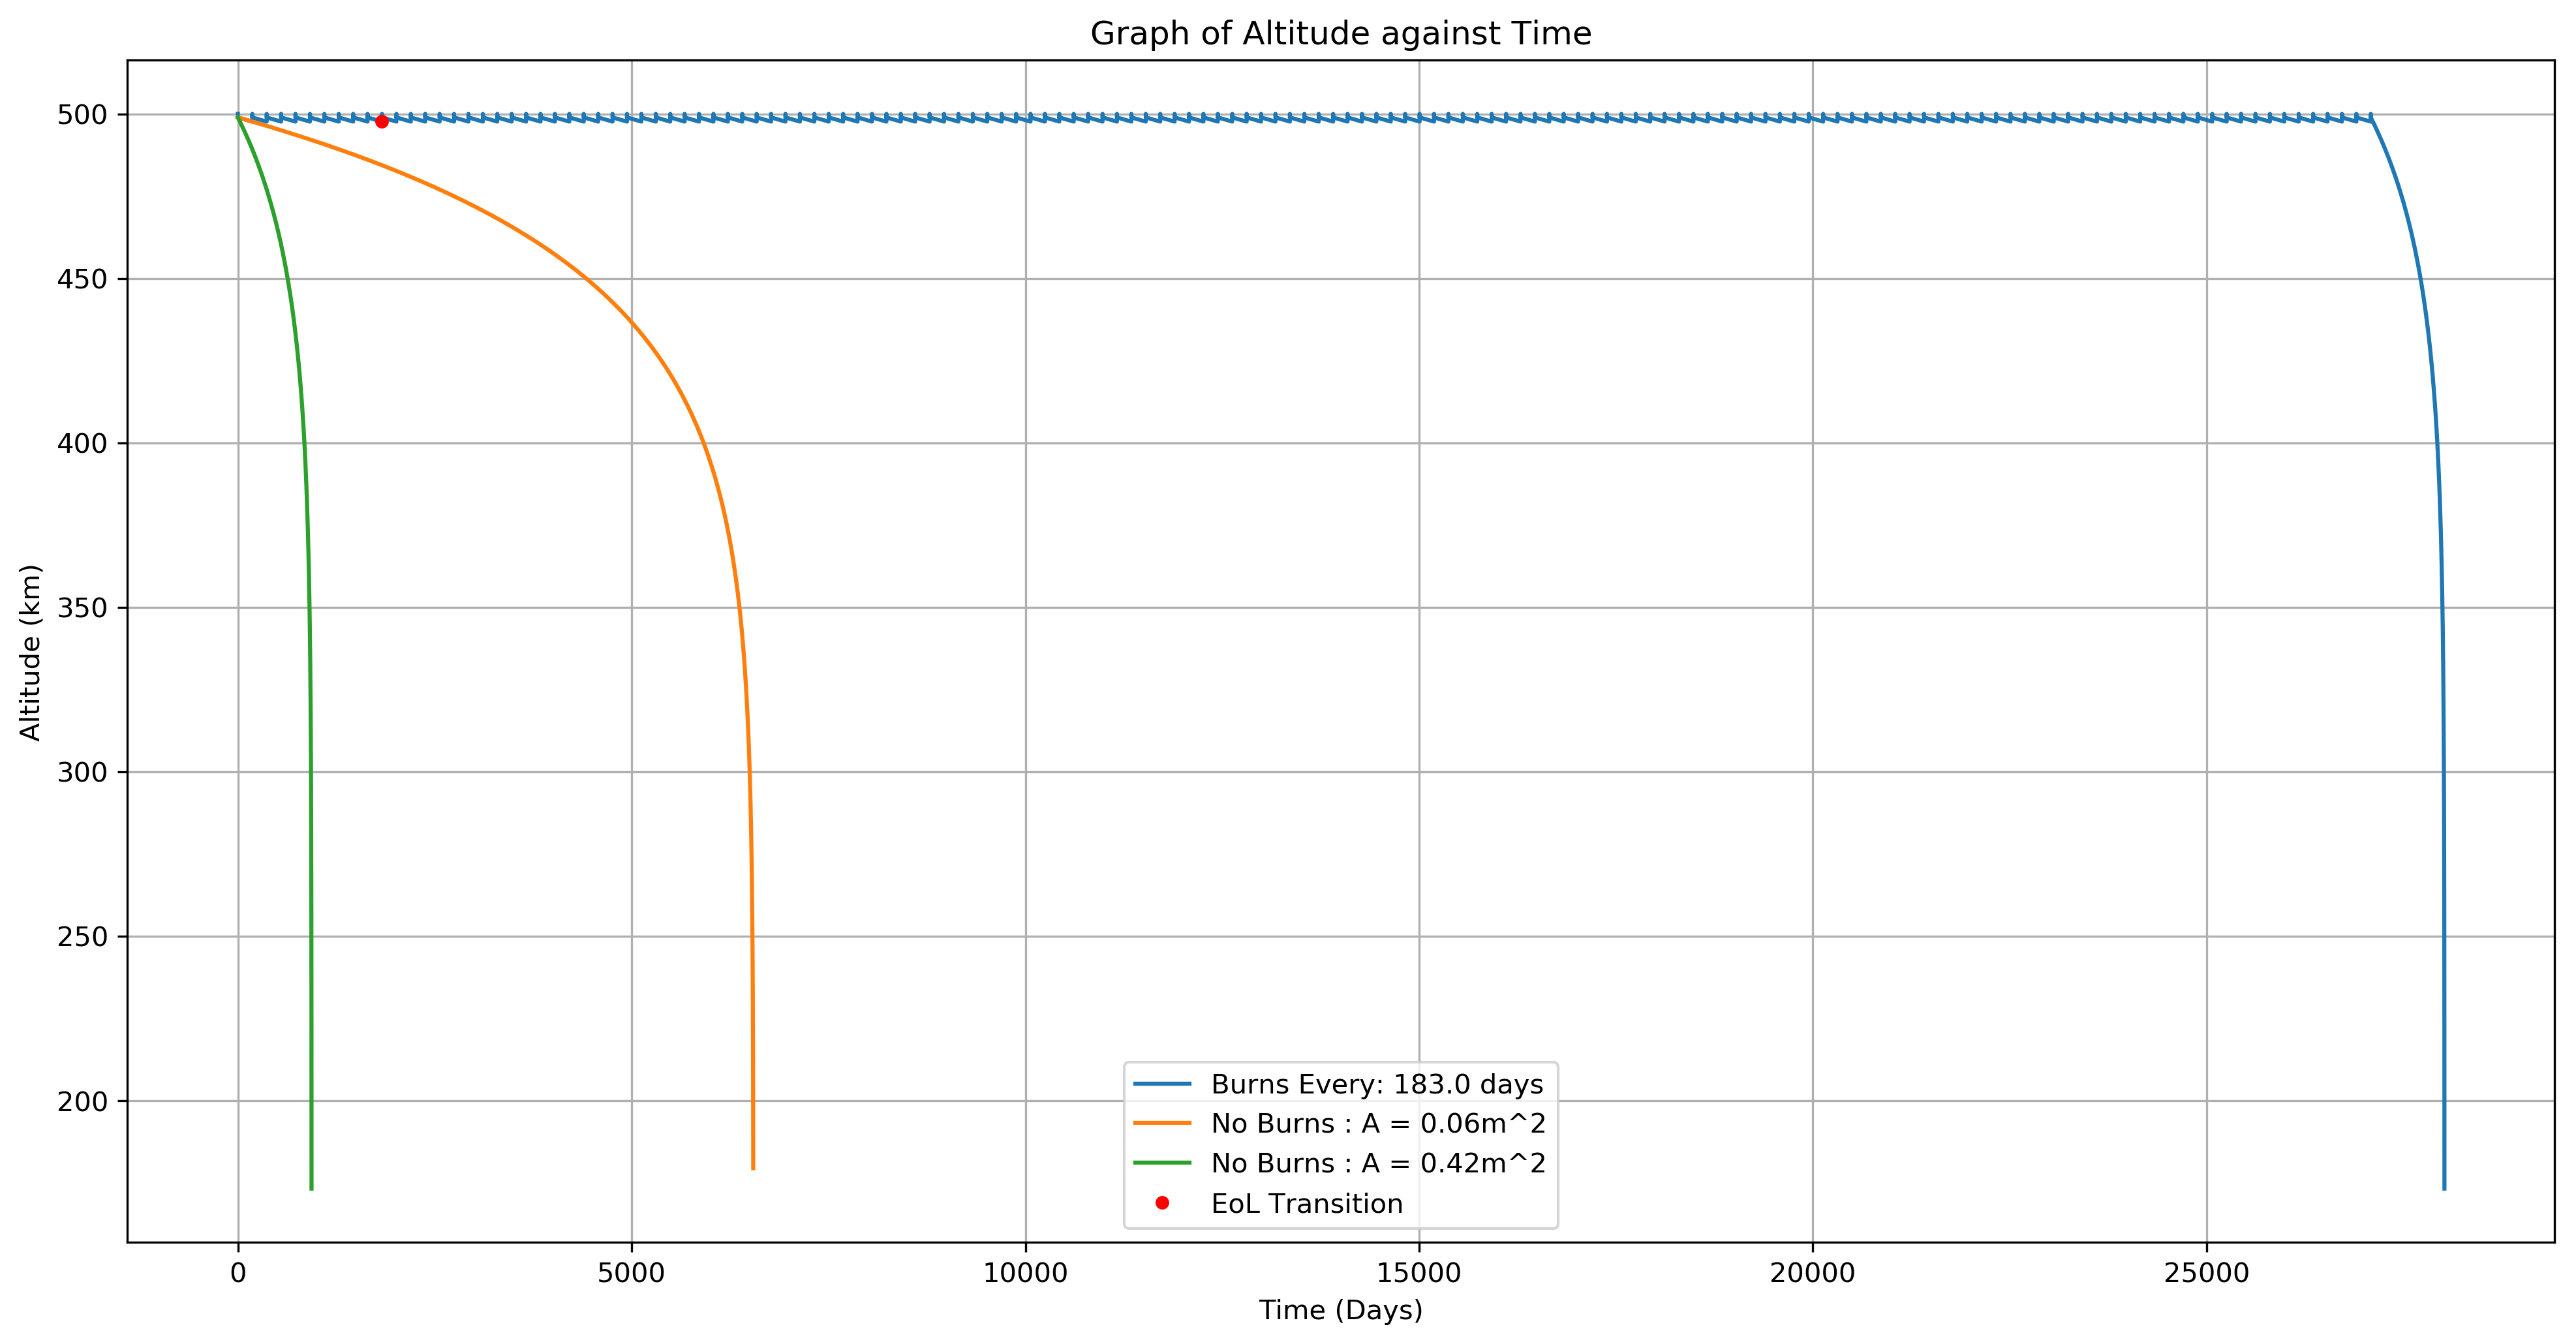

In [606]:
fig = plt.figure(figsize=(16,8), dpi = 300)

five_yr = 365*5

plt.plot(t_full, h_full, label=('Burns Every: {} days').format(days))
plt.plot(time,height, label='No Burns : A = 0.06m^2')
plt.plot(time_dec,height_dec, label='No Burns : A = 0.42m^2')

plt.plot(five_yr,decay_height,'ro', markersize=4, label='EoL Transition')

plt.title('Graph of Altitude against Time')
plt.xlabel('Time (Days)')
plt.ylabel('Altitude (km)')

# plt.ylim(180,510)
# plt.xlim(0,6750)

# plt.ylim(450,510)
# plt.xlim(0,100)

plt.grid(True)
plt.legend()
plt.show()

In [607]:
print(max(t_full)/365)

76.7657534243466


In [608]:
print("Hi I'm Dan and I like Python")

Hi I'm Dan and I like Python
